Let us first import the required packages and MAGI-X files. Please refer to README.ipynb for package version requirements.

In [1]:
# import required packages
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

# import MAGI-X packages
from magix import dynamic # dynamic module
from magix import odeinfer # inferred module

# Fully observed system

We first consider the simple case where all components share the same set of observation time points, i.e., $\tau_{1} = \cdots = \tau_{D}$, where $\tau_{d}$ is the set of observation time points of the $d$-th component.

## FitzHugh-Nagumo system

The FitzHugh-Nagumo (FN) system models the activation of an excitable system such as neuron. It is a two-component system determined by the following ODEs,
\begin{equation*}
    \left\{\begin{array}{ll}
    \dot{x}_{1} = c(x_{1} - x_{1}^{3}/3 + x_{2}) \\ 
    \dot{x}_{2} = -(x_{1} - a + b x_{2}) / c \\
    \end{array}\right.
\end{equation*}
where $a = 0.2$, $b = 0.2$, $c = 3$, and $x(0) = (-1,1)$. The groundtruth trajectory (dashed line) from $t=0$ to $t=40$ obtained via numerical integration on 321 equal spaced-out time points. We use the first half of the groundtruth trajectory to generate the 41-point noisy observations (circles) at one out of every four points, i.e., $\tau_{d} = \{t_{1},t_{5},\ldots,t_{157},t_{161}\}\;\forall d$, and save the second half for the forecasting performance evaluation. 

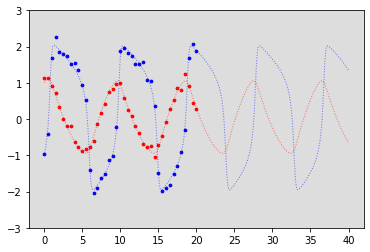

In [2]:
# experimental setting
seed = 637077689 # random seed
example = 'fn' # example
no_train = '1' # train file, '1' for full observations, '2' for partial observations
noise = [0.1,0.1] # noise level

# read data
data = np.loadtxt('data/%s/groundtruth.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = open('data/%s/train%s.txt' %(example,no_train), 'r').readlines()
if (len(obs_idx) != no_comp):
    raise ValueError('observation idx must have %d sets!' %(no_comp))
obs_idx = [[int(x) for x in ox.split(',')] for ox in obs_idx]
max_obsidx = max([max(x) for x in obs_idx])

# preprocess data
tobs = tdata[0:(max_obsidx+1)].copy()
yobs = xdata[0:(max_obsidx+1),:].copy()
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    yobs[:,i] = yobs[:,i] + np.random.normal(0,noise[i],(max_obsidx+1))
    missing = np.ones((max_obsidx+1)).astype(bool)
    missing[obs_idx[i]] = False
    yobs[missing,i] = np.nan
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

Now we apply MAGI-X for learning the unknown dynamic using only the noisy observations.

In [3]:
torch.manual_seed(seed)
magix_iteration = 2500
magix_node = [no_comp,512,no_comp]
start_time = time.time()
fOde = dynamic.nnModule(magix_node) # define neural network dynamic
magix = odeinfer.odeinfer(yobs,tobs,fOde) # call inference class
xinfer = magix.map(nEpoch=magix_iteration,verbose=True,returnX=True) # map inference
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

100/2500 iteration: 41.324854
200/2500 iteration: 19.720173
300/2500 iteration: 11.254642
400/2500 iteration: 7.013942
500/2500 iteration: 5.054813
600/2500 iteration: 4.151693
700/2500 iteration: 3.611586
800/2500 iteration: 3.263816
900/2500 iteration: 3.025114
1000/2500 iteration: 2.860716
1100/2500 iteration: 2.735727
1200/2500 iteration: 2.623023
1300/2500 iteration: 2.542587
1400/2500 iteration: 2.463457
1500/2500 iteration: 2.401761
1600/2500 iteration: 2.338000
1700/2500 iteration: 2.281433
1800/2500 iteration: 2.241551
1900/2500 iteration: 2.199068
2000/2500 iteration: 2.168263
2100/2500 iteration: 2.132358
2200/2500 iteration: 2.101451
2300/2500 iteration: 2.077966
2400/2500 iteration: 2.056552
2500/2500 iteration: 2.030744
run time: 13.00 seconds


We now compute the reconstructed trajectory (solid line) from the learned dynamic. The reconstructed trajectory refers to the trajectory computed via numerical integration with initial condition being the inferred $x_{0}$, i.e., the first point of inferred $x(\mathcal{T})$.

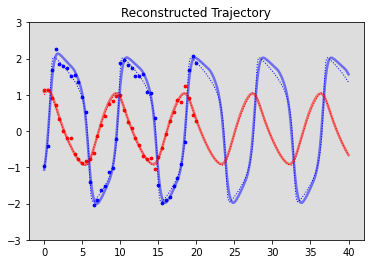

In [4]:
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = magix.predict(x0,tdata) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Reconstructed Trajectory')
plt.show()

We next compute the inferred trajectory (solid line) from the learned dynamic. The inferred trajectory refers to the $x(\mathcal{T})$ from the output of MAGI-X plus the forecast trajectory computed via numerical integration with initial condition being the last point of $x(\mathcal{T})$.

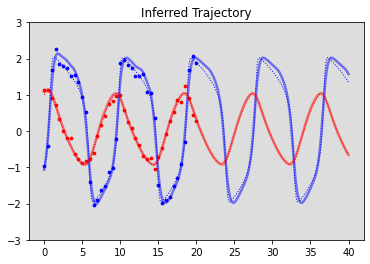

In [5]:
xl = xinfer[-1,:].squeeze() # inferred last state (initial state for forecast)
xpred = magix.predict(xl,tdata[max_obsidx:]) # forecast reconstruction
xif = np.vstack((xinfer,xpred[1:,:])) # inferred + forecast
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xif[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

## Lotka-Volterra system

The Lotka-Volterra system models the dynamics of the predator-prey interaction. It is a two-component system determined by the following ODEs,
\begin{equation*}
    \left\{\begin{array}{ll}
    \dot{x}_{1} = a x_{1} - b x_{1}x_{2} \\ 
    \dot{x}_{2} = c x_{1}x_{2} - d x_{2} \\
    \end{array}\right.
\end{equation*}
where $a = 1.5$, $b = 1$, $c = 1$, $d = 3$, and $x(0) = (5, 0.2)$. Given that both $x_{1}$ and $x_{2}$ are always strictly positive, we consider the log-transformation of the system in this paper. The groundtruth trajectory (dashed line) from $t=0$ to $t=12$ obtained via numerical integration on 321 equal spaced-out time points. Similarly, we use the first half of the groundtruth trajectory to generate the 41-point noisy observations (circles) at one out of every four points, i.e., $\tau_{d} = \{t_{1},t_{5},\ldots,t_{157},t_{161}\}\;\forall d$, and save the second half for the forecasting performance evaluation. 

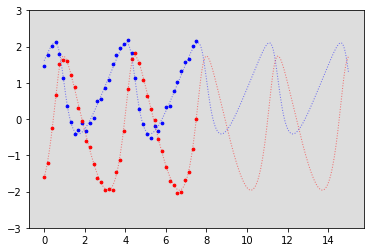

In [6]:
# experimental setting
seed = 462421835 # random seed
example = 'lv' # example
no_train = '1' # train file, '1' for full observations, '2' for partial observations
noise = [0.1,0.1] # noise level

# read data
data = np.loadtxt('data/%s/groundtruth.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = open('data/%s/train%s.txt' %(example,no_train), 'r').readlines()
if (len(obs_idx) != no_comp):
    raise ValueError('observation idx must have %d sets!' %(no_comp))
obs_idx = [[int(x) for x in ox.split(',')] for ox in obs_idx]
max_obsidx = max([max(x) for x in obs_idx])

# preprocess data
tobs = tdata[0:(max_obsidx+1)].copy()
yobs = xdata[0:(max_obsidx+1),:].copy()
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    yobs[:,i] = yobs[:,i] + np.random.normal(0,noise[i],(max_obsidx+1))
    missing = np.ones((max_obsidx+1)).astype(bool)
    missing[obs_idx[i]] = False
    yobs[missing,i] = np.nan
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

Now we apply MAGI-X for learning the unknown dynamic using only the noisy observations.

In [7]:
torch.manual_seed(seed)
magix_iteration = 2500
magix_node = [no_comp,512,no_comp]
start_time = time.time()
fOde = dynamic.nnModule(magix_node) # define neural network dynamic
magix = odeinfer.odeinfer(yobs,tobs,fOde) # call inference class
xinfer = magix.map(nEpoch=magix_iteration,verbose=True,returnX=True) # map inference
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

100/2500 iteration: 16.851838
200/2500 iteration: 10.290875
300/2500 iteration: 7.271287
400/2500 iteration: 3.478912
500/2500 iteration: 2.887475
600/2500 iteration: 2.602148
700/2500 iteration: 2.381724
800/2500 iteration: 2.080657
900/2500 iteration: 2.024975
1000/2500 iteration: 1.984960
1100/2500 iteration: 1.956196
1200/2500 iteration: 1.932858
1300/2500 iteration: 1.892918
1400/2500 iteration: 1.875905
1500/2500 iteration: 1.861282
1600/2500 iteration: 1.849306
1700/2500 iteration: 1.831846
1800/2500 iteration: 1.822204
1900/2500 iteration: 1.803555
2000/2500 iteration: 1.775907
2100/2500 iteration: 1.766489
2200/2500 iteration: 1.748498
2300/2500 iteration: 1.742319
2400/2500 iteration: 1.727481
2500/2500 iteration: 1.707559
run time: 12.94 seconds


We now compute the reconstructed trajectory (solid line) from the learned dynamic.

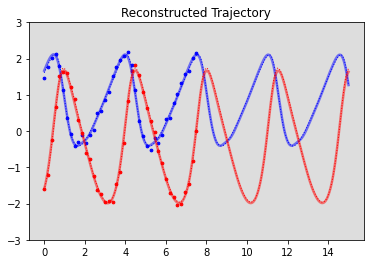

In [8]:
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = magix.predict(x0,tdata) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Reconstructed Trajectory')
plt.show()

We next compute the inferred trajectory (solid line) from the learned dynamic.

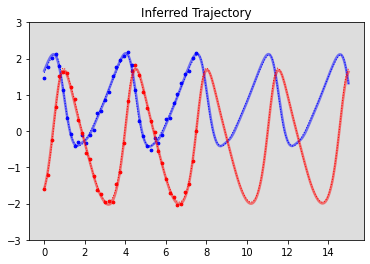

In [9]:
xl = xinfer[-1,:].squeeze() # inferred last state (initial state for forecast)
xpred = magix.predict(xl,tdata[max_obsidx:]) # forecast reconstruction
xif = np.vstack((xinfer,xpred[1:,:])) # inferred + forecast
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xif[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

## Hes1 system

The Hes1 system models the oscillation dynamic of Hes1 protein level ($x_{1}$) and Hes1 mRNA level ($x_{2}$) under the influence of a Hes1-interacting factor ($x_{3}$). It is a three-componet system determined by the following ODEs,  
\begin{equation*}
    \left\{\begin{array}{ll}
    \dot{x}_{1} = -a x_{1}x_{3} + b x_{2} - c x_{1} \\ 
    \dot{x}_{2} = -d x_{2} + e / (1+x_{1}^2) \\ 
    \dot{x}_{3} = -a x_{1}x_{3} + f/(1+x_{1}^2) - g x_{3}\\ 
    \end{array}\right.
\end{equation*}
where $a = 0.022$, $b = 0.3$, $c = 0.031$, $d = 0.028$, $e = 0.5$, $f = 20$, $g = 0.3$, and $x(0) = (1.438575, 2.037488, 17.90385)$. Similarly, given that $x_{1}$, $x_{2}$, and $x_{3}$ are always strictly positive, we consider the log-transformation of the system in this paper. The groundtruth trajectory (dashed line) from $t=0$ to $t=480$ obtained via numerical integration on 321 equal spaced-out time points. Again, we use the first half of the groundtruth trajectory to generate the 41-point noisy observations (circles) at one out of every four points, i.e., $\tau_{d} = \{t_{1},t_{5},\ldots,t_{157},t_{161}\}\;\forall d$, and save the second half for the forecasting performance evaluation. 

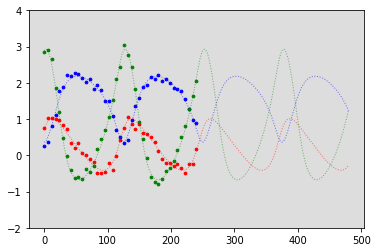

In [10]:
# experimental setting
seed = 952055769 # random seed
example = 'hes1' # example
no_train = '1' # train file, '1' for full observations, '2' for partial observations
noise = [0.1,0.1,0.1] # noise level

# read data
data = np.loadtxt('data/%s/groundtruth.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = open('data/%s/train%s.txt' %(example,no_train), 'r').readlines()
if (len(obs_idx) != no_comp):
    raise ValueError('observation idx must have %d sets!' %(no_comp))
obs_idx = [[int(x) for x in ox.split(',')] for ox in obs_idx]
max_obsidx = max([max(x) for x in obs_idx])

# preprocess data
tobs = tdata[0:(max_obsidx+1)].copy()
yobs = xdata[0:(max_obsidx+1),:].copy()
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    yobs[:,i] = yobs[:,i] + np.random.normal(0,noise[i],(max_obsidx+1))
    missing = np.ones((max_obsidx+1)).astype(bool)
    missing[obs_idx[i]] = False
    yobs[missing,i] = np.nan
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-2,4)
plt.show()

Now we apply MAGI-X for learning the unknown dynamic using only the noisy observations.

In [11]:
torch.manual_seed(seed)
magix_iteration = 2500
magix_node = [no_comp,512,no_comp]
start_time = time.time()
fOde = dynamic.nnModule(magix_node) # define neural network dynamic
magix = odeinfer.odeinfer(yobs,tobs,fOde) # call inference class
xinfer = magix.map(nEpoch=magix_iteration,verbose=True,returnX=True) # map inference
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

100/2500 iteration: 40.800005
200/2500 iteration: 25.517164
300/2500 iteration: 21.502797
400/2500 iteration: 19.443075
500/2500 iteration: 17.744248
600/2500 iteration: 16.459149
700/2500 iteration: 10.399536
800/2500 iteration: 7.389224
900/2500 iteration: 5.635060
1000/2500 iteration: 5.185029
1100/2500 iteration: 5.010981
1200/2500 iteration: 4.847928
1300/2500 iteration: 4.036863
1400/2500 iteration: 3.935835
1500/2500 iteration: 3.853011
1600/2500 iteration: 3.727622
1700/2500 iteration: 3.469159
1800/2500 iteration: 2.912220
1900/2500 iteration: 2.883886
2000/2500 iteration: 2.838406
2100/2500 iteration: 2.803235
2200/2500 iteration: 2.772923
2300/2500 iteration: 2.745687
2400/2500 iteration: 2.719669
2500/2500 iteration: 2.698029
run time: 16.33 seconds


We now compute the reconstructed trajectory (solid line) from the learned dynamic.

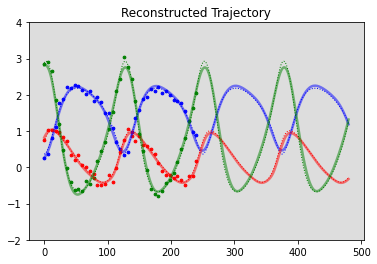

In [12]:
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = magix.predict(x0,tdata) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-2,4)
plt.title('Reconstructed Trajectory')
plt.show()

We next compute the inferred trajectory (solid line) from the learned dynamic.

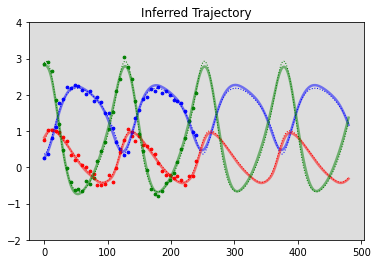

In [13]:
xl = xinfer[-1,:].squeeze() # inferred last state (initial state for forecast)
xpred = magix.predict(xl,tdata[max_obsidx:]) # forecast reconstruction
xif = np.vstack((xinfer,xpred[1:,:])) # inferred + forecast
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xif[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-2,4)
plt.title('Inferred Trajectory')
plt.show()

# Partially observed system

MAGI-X is the first unknown ODEs inference method that provides a practical and complete solution to handle systems with asynchronous observation times, which $\tau_{1} \neq \cdots \neq \tau_{D}$. This is commonly seen in practice, since sensor failure or human error could possibly lead to missing observations of some components but not necessary the whole system at a particular time point.

## FitzHugh-Nagumo system

We simulate the noisy observations in the following setting: we only allow the observation of one component at each time point. For a fair comparison to the results of the fully observed system, we keep the number of observations to be about 41, and thus letting $\tau_{1} = \{t_{1},t_{5},\ldots,t_{161}\}$ and $\tau_{2} = \{t_{3},t_{7},\ldots,t_{159}\}$. 

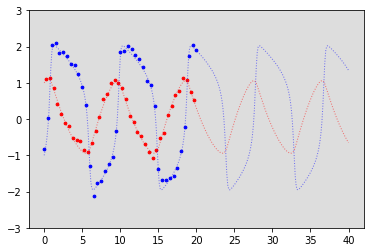

In [14]:
# experimental setting
seed = 278515925 # random seed
example = 'fn' # example
no_train = '2' # train file, '1' for full observations, '2' for partial observations
noise = [0.1,0.1] # noise level

# read data
data = np.loadtxt('data/%s/groundtruth.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = open('data/%s/train%s.txt' %(example,no_train), 'r').readlines()
if (len(obs_idx) != no_comp):
    raise ValueError('observation idx must have %d sets!' %(no_comp))
obs_idx = [[int(x) for x in ox.split(',')] for ox in obs_idx] # observation time point index
max_obsidx = max([max(x) for x in obs_idx]) 

# preprocess data
tobs = tdata[0:(max_obsidx+1)].copy()
yobs = xdata[0:(max_obsidx+1),:].copy()
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    yobs[:,i] = yobs[:,i] + np.random.normal(0,noise[i],(max_obsidx+1))
    missing = np.ones((max_obsidx+1)).astype(bool)
    missing[obs_idx[i]] = False
    yobs[missing,i] = np.nan
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

Now we apply MAGI-X for learning the unknown dynamic using only the noisy observations.

In [15]:
torch.manual_seed(seed)
magix_iteration = 2500
magix_node = [no_comp,512,no_comp]
start_time = time.time()
fOde = dynamic.nnModule(magix_node) # define neural network dynamic
magix = odeinfer.odeinfer(yobs,tobs,fOde) # call inference class
xinfer = magix.map(nEpoch=magix_iteration,verbose=True,returnX=True) # map inference
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

100/2500 iteration: 32.069719
200/2500 iteration: 12.685274
300/2500 iteration: 7.722149
400/2500 iteration: 5.746477
500/2500 iteration: 4.720436
600/2500 iteration: 4.154626
700/2500 iteration: 3.821544
800/2500 iteration: 3.596258
900/2500 iteration: 3.416534
1000/2500 iteration: 3.276439
1100/2500 iteration: 3.151235
1200/2500 iteration: 3.050259
1300/2500 iteration: 2.959807
1400/2500 iteration: 2.883901
1500/2500 iteration: 2.810038
1600/2500 iteration: 2.739641
1700/2500 iteration: 2.668412
1800/2500 iteration: 2.608070
1900/2500 iteration: 2.544132
2000/2500 iteration: 2.476277
2100/2500 iteration: 2.261206
2200/2500 iteration: 2.201727
2300/2500 iteration: 2.179018
2400/2500 iteration: 2.159423
2500/2500 iteration: 2.143291
run time: 12.75 seconds


We now compute the reconstructed trajectory (solid line) from the learned dynamic.

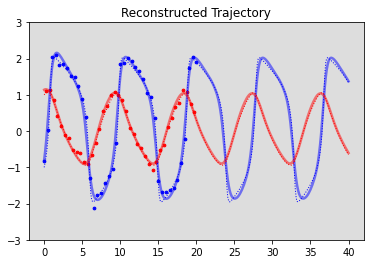

In [16]:
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = magix.predict(x0,tdata) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Reconstructed Trajectory')
plt.show()

We next compute the inferred trajectory (solid line) from the learned dynamic.

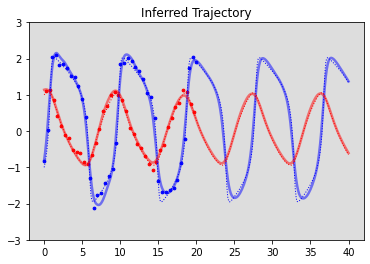

In [17]:
xl = xinfer[-1,:].squeeze() # inferred last state (initial state for forecast)
xpred = magix.predict(xl,tdata[max_obsidx:]) # forecast reconstruction
xif = np.vstack((xinfer,xpred[1:,:])) # inferred + forecast
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xif[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

## Lotka-Volterra system

We simulate the noisy observations under the same setting of the FitzHugh-Nagumo example: we only allow the observation of one component at each time point. For a fair comparison to the results of the fully observed system, we keep the number of observations to be about 41, and thus letting $\tau_{1} = \{t_{1},t_{5},\ldots,t_{161}\}$ and $\tau_{2} = \{t_{3},t_{7},\ldots,t_{159}\}$. 

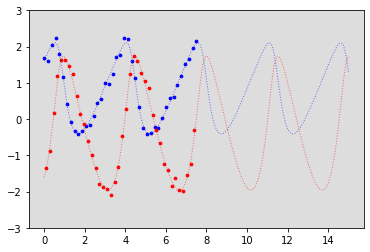

In [18]:
# experimental setting
seed = 969894650 # random seed
example = 'lv' # example
no_train = '2' # train file, '1' for full observations, '2' for partial observations
noise = [0.1,0.1] # noise level

# read data
data = np.loadtxt('data/%s/groundtruth.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = open('data/%s/train%s.txt' %(example,no_train), 'r').readlines()
if (len(obs_idx) != no_comp):
    raise ValueError('observation idx must have %d sets!' %(no_comp))
obs_idx = [[int(x) for x in ox.split(',')] for ox in obs_idx] # observation time point index
max_obsidx = max([max(x) for x in obs_idx]) 

# preprocess data
tobs = tdata[0:(max_obsidx+1)].copy()
yobs = xdata[0:(max_obsidx+1),:].copy()
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    yobs[:,i] = yobs[:,i] + np.random.normal(0,noise[i],(max_obsidx+1))
    missing = np.ones((max_obsidx+1)).astype(bool)
    missing[obs_idx[i]] = False
    yobs[missing,i] = np.nan
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

Now we apply MAGI-X for learning the unknown dynamic using only the noisy observations.

In [ ]:
torch.manual_seed(seed)
magix_iteration = 2500
magix_node = [no_comp,512,no_comp]
start_time = time.time()
fOde = dynamic.nnModule(magix_node) # define neural network dynamic
magix = odeinfer.odeinfer(yobs,tobs,fOde) # call inference class
xinfer = magix.map(nEpoch=magix_iteration,verbose=True,returnX=True) # map inference
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

100/2500 iteration: 21.272471
200/2500 iteration: 13.696690
300/2500 iteration: 7.548482
400/2500 iteration: 6.184453
500/2500 iteration: 5.476605
600/2500 iteration: 3.547266
700/2500 iteration: 2.486227
800/2500 iteration: 2.222970
900/2500 iteration: 2.159682
1000/2500 iteration: 2.110258
1100/2500 iteration: 2.063731
1200/2500 iteration: 2.033444
1300/2500 iteration: 1.990076
1400/2500 iteration: 1.960553
1500/2500 iteration: 1.939632
1600/2500 iteration: 1.906748


We now compute the reconstructed trajectory (solid line) from the learned dynamic.

In [ ]:
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = magix.predict(x0,tdata) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Reconstructed Trajectory')
plt.show()

We next compute the inferred trajectory (solid line) from the learned dynamic.

In [ ]:
xl = xinfer[-1,:].squeeze() # inferred last state (initial state for forecast)
xpred = magix.predict(xl,tdata[max_obsidx:]) # forecast reconstruction
xif = np.vstack((xinfer,xpred[1:,:])) # inferred + forecast
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xif[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

## Hes1 system

Let us now consider a even more challenging setting for the Hes1 system by letting $\tau_{1} = \{t_{5},t_{9},t_{17},t_{21},\ldots,t_{161}\}$, $\tau_{2} = \{t_{1},t_{9},t_{13},t_{21},\ldots,t_{156}\}$, and $\tau_{3} = \{t_{1},t_{5},t_{13},t_{17},\ldots,t_{161}\}$. Here, (i) only two out of three components are observable at a particular time, (ii) the observation times are no longer equal spaced-out, (iii) only about 28 observations are available for each component, which is one third less than the 41 observations considered previously.

In [ ]:
# experimental setting
seed = 898503136 # random seed
example = 'hes1' # example
no_train = '2' # train file, '1' for full observations, '2' for partial observations
noise = [0.1,0.1,0.1] # noise level

# read data
data = np.loadtxt('data/%s/groundtruth.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = open('data/%s/train%s.txt' %(example,no_train), 'r').readlines()
if (len(obs_idx) != no_comp):
    raise ValueError('observation idx must have %d sets!' %(no_comp))
obs_idx = [[int(x) for x in ox.split(',')] for ox in obs_idx] # observation time point index
max_obsidx = max([max(x) for x in obs_idx]) 

# preprocess data
tobs = tdata[0:(max_obsidx+1)].copy()
yobs = xdata[0:(max_obsidx+1),:].copy()
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    yobs[:,i] = yobs[:,i] + np.random.normal(0,noise[i],(max_obsidx+1))
    missing = np.ones((max_obsidx+1)).astype(bool)
    missing[obs_idx[i]] = False
    yobs[missing,i] = np.nan
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-2,4)
plt.show()

Now we apply MAGI-X for learning the unknown dynamic using only the noisy observations.

In [ ]:
torch.manual_seed(seed)
magix_iteration = 2500
magix_node = [no_comp,512,no_comp]
start_time = time.time()
fOde = dynamic.nnModule(magix_node) # define neural network dynamic
magix = odeinfer.odeinfer(yobs,tobs,fOde) # call inference class
xinfer = magix.map(nEpoch=magix_iteration,verbose=True,returnX=True) # map inference
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

We now compute the reconstructed trajectory (solid line) from the learned dynamic.

In [ ]:
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = magix.predict(x0,tdata) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-2,4)
plt.title('Reconstructed Trajectory')
plt.show()

We next compute the inferred trajectory (solid line) from the learned dynamic.

In [ ]:
xl = xinfer[-1,:].squeeze() # inferred last state (initial state for forecast)
xpred = magix.predict(xl,tdata[max_obsidx:]) # forecast reconstruction
xif = np.vstack((xinfer,xpred[1:,:])) # inferred + forecast
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xif[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(tobs, yobs[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-2,4)
plt.title('Inferred Trajectory')
plt.show()